This notebook applies hierarchical bayesian modeling using topographical remote sensing product

In [16]:
import sys
sys.path.append('..')
import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *

from src.utils import *
from src.params import *
tqdm.pandas()

%matplotlib inline

# Data Pre-Processing

In [6]:
df, basin_idx, basins, coords = read_data(file_dir='../data/hierarchical_septics_v2.csv',
        cols=['ppt_2013', 'water_dist', 'hydraulic_c','median_hse', 'dem', 'flow'], is_balanced=True)

balancing...
repairs: 7.6567198704603285%, non-repairs: 92.34328012953968%
processing soil hydraulic data...
acquiring housing information...
processing DEM and flow information...


# Hierarchical Bayesian Model

- Group septic systems based on their basin (~1560 basins)
- The effect of precipitation, distance to water bodies, soil characteristic, housing, topography to septic's status

The new variable, flow accumulation or DEM ($f$):

$$
\begin{align}
    \textbf{Flow or DEM parameters}\\
    \beta_{f,k} \sim \Gamma_{f,k}(\alpha = \alpha_f, \beta=\beta_f)\\
    \alpha_f \sim HN_f(\sigma=1)\\
    \beta_f \sim HN_f(\sigma=5)\\
\end{align}
$$

\begin{equation*}
Y_{i} \sim Bernoulli(\theta_{i})\tag{1}
\end{equation*}

\begin{equation*}
\theta_{i} = \sigma(\beta_{c,i} + \beta_{w,i}.waterdist + \beta_{p,i}.precip + \beta_{h,i}.hydraulics + \beta_{s,i}.hseval + \beta_{t,i}.elev) \tag{2}
\end{equation*}

\begin{equation*}
\textbf{Intercept parameters}\\
    \beta_{c,i} \sim N_{c,i}(\mu=\mu_{c}, \sigma=\theta_{c})\\
    \text{where }\mu_{c} \sim N_c(\mu=0, \sigma=10) \quad and \quad \theta_{c} \sim HN_c(\sigma=10) \tag{3}
\end{equation*}

\begin{equation*}
\textbf{Water distance parameters}\\
    \beta_{w,i} \sim Exp_{w,i}(\sigma=\sigma_w)\\
    \text{where }\quad \sigma_w \sim HN_p(\sigma=10) \tag{4}
\end{equation*}

\begin{equation*}
\textbf{Precipitation parameters}\\
    \beta_{p,i} \sim N_{p,i}(\mu=\mu_{p}, \sigma=\sigma_p)\\
    \text{where }\mu_{p} \sim N_p(\mu=0, \sigma=10) \quad and \quad \sigma_p \sim HN_p(\sigma=10) \tag{4}
\end{equation*}

\begin{equation*}
\textbf{Soil hydraulic conductivity parameters}\\
    \beta_{h,i} \sim U_{h,i}(lower=-2,upper=\sigma_h)\\
    \text{where }\sigma_h \sim HN_h(\sigma=10) \tag{5}
\end{equation*}

\begin{equation*}
\textbf{Socio-economic parameters}\\
    \beta_{s,i} \sim N_{s,i}(\mu=0, \sigma=\sigma_s)\\
    \text{where }\sigma_s \sim HN_s(\sigma=5) \tag{6}
\end{equation*}

\begin{equation*}
\textbf{Topography (elevation) parameters}\\
    \beta_{t,i} \sim Exp_{t,i}(\lambda=\lambda_t)\\
    \text{where }\lambda_t \sim HN_t(\sigma=5) \tag{7}
\end{equation*}

In [10]:
# Modeling
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    water_d = pm.Data('water_d', df.water_dist_norm.values, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2013_norm.values, dims='septic')
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values, dims='septic')
    hse_d = pm.Data('hse_d', df.median_hse_norm.values, dims='septic')
    flow_d = pm.Data('flow_d', df.flow_norm.values, dims='septic')
    dem_d = pm.Data('dem_d', df.dem_norm.values, dims='septic')

    # global model parameters
    wtr_beta = pm.HalfNormal('wtr_beta', sigma=10)
    ppt_mu = pm.Normal('ppt_mu', mu=0, sigma=10)
    ppt_sig = pm.HalfNormal('ppt_sig', sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=5)
    flow_alpha = pm.HalfNormal('flow_alpha', sigma=1.)
    flow_beta = pm.HalfNormal('flow_beta', sigma=5)
    dem_beta = pm.HalfNormal('dem_beta', sigma=5)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    wtr_dist = pm.Exponential('wtr_dist', lam=wtr_beta, dims='basin')
    ppt = pm.Normal('ppt', mu=ppt_mu, sigma=ppt_sig, dims='basin')
    hydr = pm.Uniform('hydr', lower=-2, upper=hydr_sig, dims='basin')
    hse = pm.Normal('hse', mu=0, sigma=hse_sig, dims='basin')
    flow = pm.Gamma('flow', alpha=flow_alpha, beta=flow_beta, dims='basin')
    dem = pm.Exponential('dem', lam=dem_beta, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + wtr_dist[basin] * water_d 
                                    + ppt[basin] * ppt_d
                                    + hydr[basin] * hydr_d
                                    + hse[basin] * hse_d
                                    + flow[basin] * flow_d
                                    + dem[basin] * dem_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=200, cores=4, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, dem, flow, hse, hydr, ppt, wtr_dist, sigma_c, mu_c, dem_beta, flow_beta, flow_alpha, hse_sig, hydr_sig, ppt_sig, ppt_mu, wtr_beta]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 81 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [11]:
graph = pm.model_graph.model_to_graphviz(model)
graph.render(filename='../docs/single_level')

'../docs/single_level.pdf'

In [14]:
# evaluate model (just dem)
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

accuracy is: 90.83850931677019%


# Evaluation

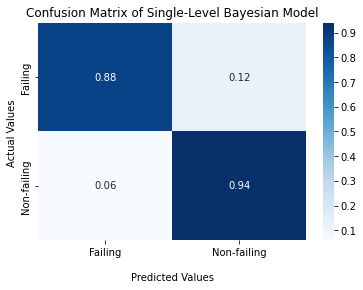

In [15]:
plot_confusion(y, y_pred, title='Confusion Matrix of Single-Level Bayesian Model')